In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Just exploring CNN's
* > *Here i'll be exploring CNN's using tensorflow's sequential API, Functional API's*
* > *Along with above, later in this notebook will be using resnets and transfer learning to identify the fruit class*

# *Read image data and explore few images of all classes*
* *Lets read train,test,validation image datasests and check the size/shape of data*
* *Also perform data scaling and check for class distribution*

# Imports

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt

> *Here, we shall make use of keras image_dataset_from_directory method to read images from directories that are seggregated into respective class like in the image*
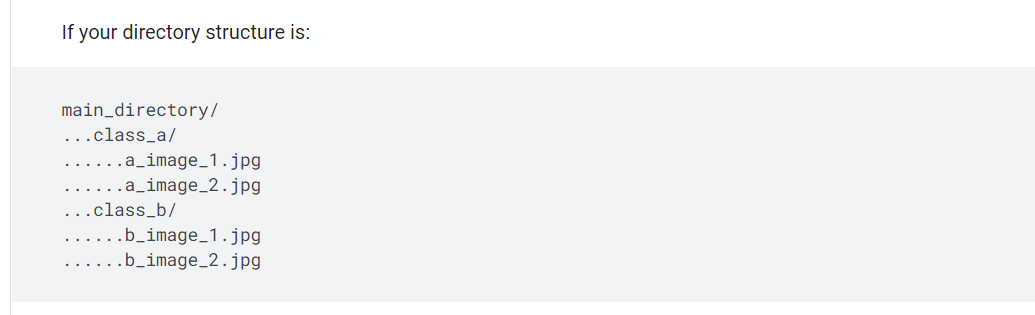
> * [Here is the link to image_dataset_from_directory usage](http://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)
> *[Here in the youtube video about tf Dataset](https://www.youtube.com/watch?v=VFEOskzhhbc)

In [91]:
batch_size = 10
img_height = 224
img_width = 224

train_dset = tf.keras.utils.image_dataset_from_directory(
  "../input/fruit-and-vegetable-image-recognition/train",
  image_size=(img_height, img_width),
  batch_size=batch_size)

valid_dset = tf.keras.utils.image_dataset_from_directory(
  "../input/fruit-and-vegetable-image-recognition/validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_dset = tf.keras.utils.image_dataset_from_directory(
    "../input/fruit-and-vegetable-image-recognition/test",
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
 )

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


In [92]:
class_labels = train_dset.class_names
len(class_labels)

36

In [93]:
AUTOTUNE = tf.data.AUTOTUNE

train_dset = train_dset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dset = test_dset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_dset = valid_dset.cache().prefetch(buffer_size=AUTOTUNE)

# Visualize train images
[Visualizing batch images](https://www.tensorflow.org/tutorials/images/classification)

In [ ]:
##iterate through 6 images from one batch and visualize
for images,labels in train_dset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(6):
        plt.subplot(3,3,i+1)
        if(i==0):
            inp_shape = images[i].numpy().astype('uint8').shape
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_labels[labels[i]])
        plt.axis("off")

### *Input image size and channels* 

In [ ]:
print('Shape of image : '+str(inp_shape))

# Keras Sequential API Model implementation

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

## Parameter tuning and their impact
* *Initial model architecture - i had 250,150,100 filters in each layer, padding=valid in all layers,filtersize=2 and as expected learning was slow but as the epochs progressed there was no improvement in the accuracy*
* *Then, 32,16,10 resulted in fast learning plus with 5 epochs the training accuracy turned out to be 84%*
* *Using above filters, without Normalization after each 2D convolution = below is the training and validation scores and losses*
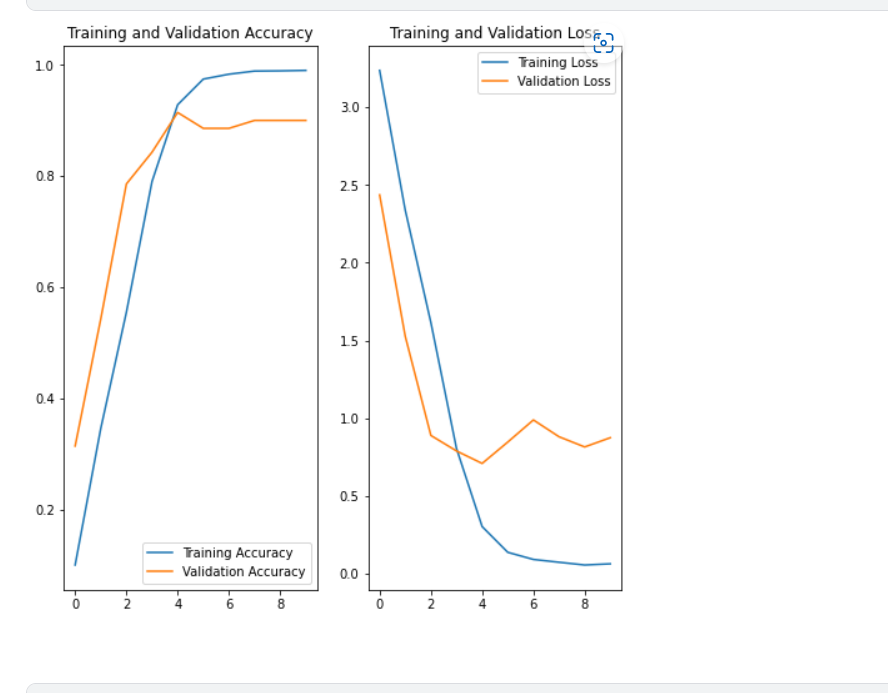

* *Using above parameters and WITH regularization layers after each convolution, below is the performance*
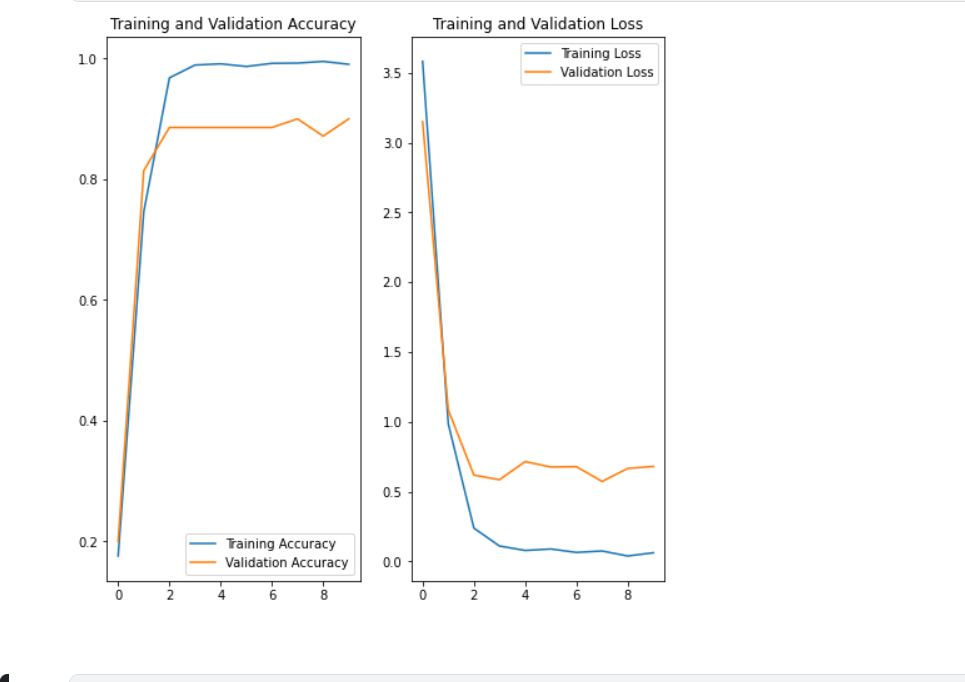
* *After adding an addition layer of Conv2D->Norm->Relu activation->MaxPool2D as initial stage of model, below is the performance(and it jumped by ~5% compared to previous one)*
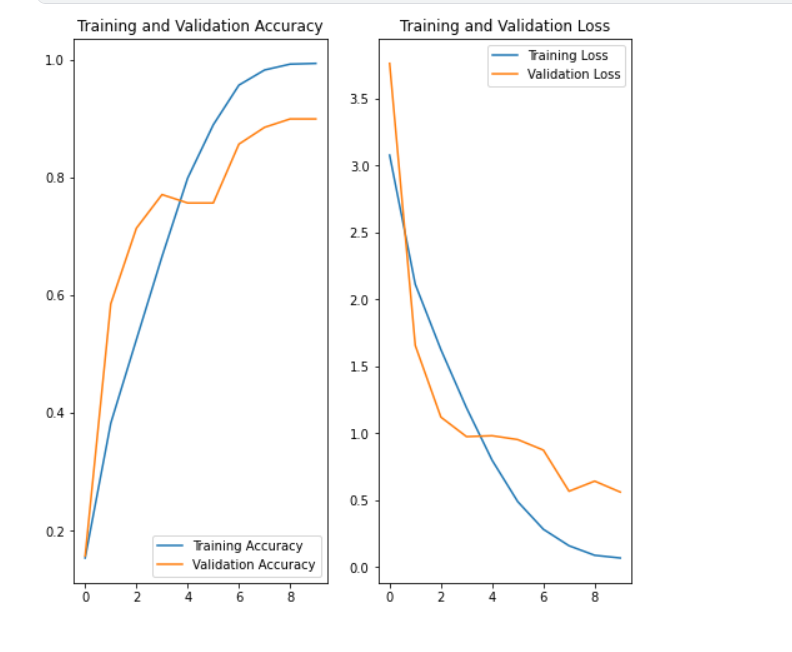
#### By looking at above 2 results - its clearly overfitting on training images

In [ ]:

model = keras.Sequential([
    layers.ZeroPadding2D(padding=3),
    layers.Rescaling(1./255.0, input_shape=(img_height,img_width,3)),
    layers.Conv2D(filters=64,kernel_size=(2,2),strides=(1,1)),
    layers.BatchNormalization(axis=-1),
    layers.ReLU(),
    layers.MaxPool2D(strides=(2,2),padding='valid'),
    layers.Conv2D(filters=32,kernel_size=(2,2),strides=(1,1)),
    layers.BatchNormalization(axis=-1),
    layers.ReLU(),
    layers.MaxPool2D(strides=(2,2),padding='valid'),
    layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2)),
    layers.BatchNormalization(axis=-1),
    layers.ReLU(),
    layers.MaxPool2D(strides=(2,2),padding='valid'),
    layers.Conv2D(filters=10,kernel_size=(2,2),strides=(1,1)),
    layers.BatchNormalization(axis=-1),
    layers.ReLU(),
    layers.Flatten(),
    layers.Dense(units=len(class_labels))
])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
train_history = model.fit(train_dset,validation_data=valid_dset,epochs=10)

In [124]:
def plot_model_train_performance(train_history,epoch_range=10):
    acc = train_history.history['accuracy']
    val_acc = train_history.history['val_accuracy']

    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']

    epochs_range = range(epoch_range)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Save Entire Model
> [Here's link to how to save trained model to disc using tensorflow](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model)

In [ ]:
model.save('cnn_fruit_seq_model')

In [ ]:
model = keras.models.load_model('cnn_fruit_seq_model')

In [ ]:
def predict_dataset(dataset):
    predicted_labels=np.array([])
    true_labels =np.array([])

    for images,y_true in dataset:
        ## a batch has 10 images , there are 36 classes that each image could probably belong to
        y_pred_2d = model.predict(images)
        #as the output layer is softmax, we would take the predicted class with highest score/probablity
        y_pred = np.argmax(y_pred_2d,axis=-1)
        predicted_labels=np.concatenate([predicted_labels,y_pred])
        #y_true is 2d arrays of 10 x 36 items , 10 images and 36 probable classes but y_true will have '1' as the 
        #actual class of an image
        true_labels=np.concatenate([true_labels,np.argmax(y_true,axis=-1)])
    return (predicted_labels,true_labels)

In [ ]:
(predicted_labels,true_labels) = predict_dataset(test_dset)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(true_labels,predicted_labels))

In [25]:
def print_image(image_pxls,top=1):
    '''
    This method takes in array of images(by their pixels) and plots them
    image_pxls : of type ndarray B x m x n x c where B is the batch size, image is of size mxn with c number of channels
    '''
    plt.figure(figsize=(11,11))
    for i in range(top-1):
        plt.subplot(3,3,i+1)
        plt.imshow(image_pxls[i][:,:,:3])
        plt.axis("off")

In [9]:
def print_batch1(dataset):
    batch_ = dataset.take(1)
    #print(batch_)
    #(predicted_labels,true_labels)=predict_dataset(batch_)
    #print(class_labels)
    #print(predicted_labels)
    plt.figure(figsize=(10,10))
    for images,true_labels in batch_:
        #print(true_labels)
        for i in range(9):
            plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(f'true:{class_labels[np.argmax(true_labels[i],axis=-1)]},pred:{class_labels[int(np.argmax(model.predict(tf.expand_dims(images[i],0)),axis=-1))]}')
            plt.axis('off')

In [10]:
print_batch1(test_dset)

2022-09-21 14:36:18.801592: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-21 14:36:20.201704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
2022-09-21 14:36:22.889659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

In [ ]:
image_to_predict = tf.keras.utils.load_img('../input/fruit-and-vegetable-image-recognition/test/ginger/Image_1.jpg',target_size=(img_height,img_width))
img_pxl = tf.keras.utils.img_to_array(image_to_predict)
img_pxl = tf.expand_dims(img_pxl,axis=0)
img_pxl.shape

In [ ]:
prediction = model.predict(img_pxl)

In [ ]:
plt.imshow(img_pxl.numpy().astype('uint8').reshape(224,224,3))
plt.title(f'true:ginger,predicted:{class_labels[np.argmax(prediction.flatten(),axis=-1)]}')
plt.axis('off')

### Next to explore on transfer learning using imagenet and resnets
### Also faster model performance for devices with less computation power  - like mobile (1D conventions, bottleneck layers)
### and Visualize each layers activation outputs to get bit of more intuition

# Explore Transfer learning using already trained models with reusing weights
* *Here we shall also try to look at what each layer's output looks like - intuition into each layers ouput*

In [80]:
from tensorflow.keras.applications import Xception,MobileNetV2

>  *Here let us check the output of fist layer in VGG network*

In [21]:

testbatch_1=test_dset.take(1)

In [22]:
model = Xception()
model = keras.Model(inputs=model.inputs,outputs=model.layers[1].output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 149, 149, 32)      864       
Total params: 864
Trainable params: 864
Non-trainable params: 0
_________________________________________________________________


In [23]:
def print_layer_activations():
    layer_pred = model.predict(testbatch_1)
    print(layer_pred.shape)
    print_image(layer_pred,10)

# Xception - Layer1 outcome intuition

(10, 149, 149, 32)


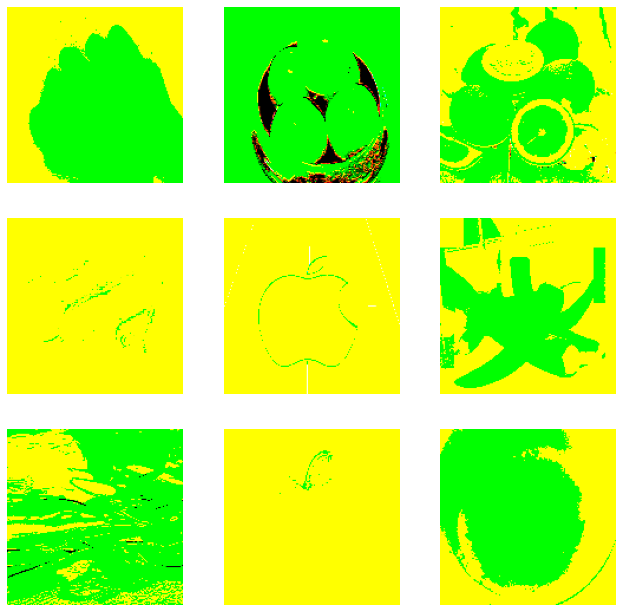

In [26]:
print_layer_activations()

# Xception - Layer2 outcome intuition

In [27]:
model = Xception()
model = keras.Model(inputs=model.inputs,outputs=model.layers[2].output)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 149, 149, 32)      864       
_________________________________________________________________
block1_conv1_bn (BatchNormal (None, 149, 149, 32)      128       
Total params: 992
Trainable params: 928
Non-trainable params: 64
_________________________________________________________________


(10, 149, 149, 32)


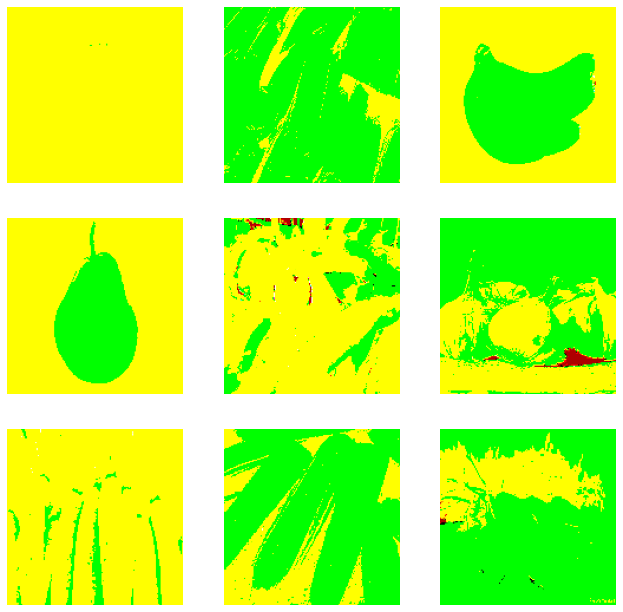

In [28]:
print_layer_activations()

# MobileNet & Transfer learning - All layers except the fully connected layers
* Here MobileNetV2 network architecture with trained weights on imagenet dataset is used.
* MobileNetV2 is a network architecture that works well in less computation powered devices such as mobile
* Bottleneck convolutions on start of each stages and end of each stage makes this work with less computational devices without downperforming accuracy

In [108]:
model_ = MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3),pooling='avg')

In [109]:
model_.trainable=False
model_.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_13[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [110]:
inputs = model_.input

In [111]:
#x = layers.Flatten()(xception_model.output)
x = layers.Dense(units=128,activation='relu')(model_.output)
x = layers.Dense(units=128,activation='relu')(x)
outputs = layers.Dense(units=36,activation='softmax')(x)

In [112]:
model = keras.Model(inputs,outputs)

In [113]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_13[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [114]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [115]:
class haltCallback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('loss')<=0.1):
            print("\n\n\nReached 0.01 loss value so cancelling training!\n\n\n")
            self.model.stop_training = True

In [116]:
stopTrainingCallback = haltCallback()

In [117]:
history=model.fit(train_dset,epochs=20,validation_data=valid_dset,callbacks=[stopTrainingCallback])

Epoch 1/20
312/312 [==============================] - 52s 155ms/step - loss: 3.2425 - accuracy: 0.1339 - val_loss: 2.5563 - val_accuracy: 0.3048
Epoch 2/20
312/312 [==============================] - 47s 150ms/step - loss: 2.6251 - accuracy: 0.2610 - val_loss: 1.9292 - val_accuracy: 0.4501
Epoch 3/20
312/312 [==============================] - 47s 151ms/step - loss: 2.2803 - accuracy: 0.3541 - val_loss: 1.7427 - val_accuracy: 0.4986
Epoch 4/20
312/312 [==============================] - 47s 150ms/step - loss: 2.0333 - accuracy: 0.4215 - val_loss: 1.4158 - val_accuracy: 0.5954
Epoch 5/20
312/312 [==============================] - 47s 152ms/step - loss: 1.8403 - accuracy: 0.4623 - val_loss: 1.2816 - val_accuracy: 0.6866
Epoch 6/20
312/312 [==============================] - 45s 146ms/step - loss: 1.6631 - accuracy: 0.5120 - val_loss: 1.0856 - val_accuracy: 0.7037
Epoch 7/20
312/312 [==============================] - 46s 149ms/step - loss: 1.5044 - accuracy: 0.5589 - val_loss: 1.0844 - val_ac

In [123]:
history

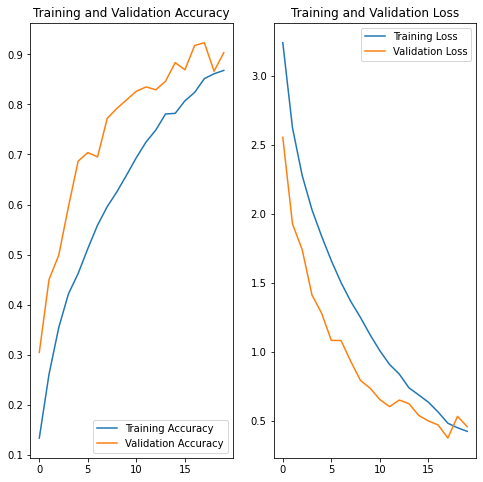

In [125]:
plot_model_train_performance(history,20)